# Getting the rating from the reviews

In [441]:
# !pip install -q --disable-pip-version-check -r ../requirements.txt

In [442]:
# Randomization for seed reproduction
import random

# Matrix operations
import numpy as np

# Dataframes
import pandas as pd

# Regular Expressions
import re

# Import unidecode (to remove accents from words)
from unidecode import unidecode

# Import wordcloud
from wordcloud import WordCloud

# Sklearn Utilities
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation

# Visualize the information contained in a topic model
import pyLDAvis
from pyLDAvis import gensim as gensimvis

import gensim
from gensim import corpora

# Charts
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# SciKit Learn Utilities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.manifold import TSNE
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix

# Natural Language Toolkit
import nltk
from nltk.tokenize import word_tokenize

# Language Detection
from langdetect import detect


In [443]:
# Set a random seed for reproducibility
random_seed = 10
np.random.seed(random_seed)
random.seed(random_seed)

# Preprocessing

## 1. Displaying the data

In [444]:
reviews_df = pd.read_csv('../data/Big_AHR.csv', index_col=0)
reviews_df.head()

,title,rating,review_text,location,hotel,label
0,Excelente y personal amable,5,Un hotel muy bueno. El personal fue muy amabl...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
1,Céntrico,4,"Muy buen hotel al nivel de lo esperado, habita...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
2,Hotel excepcional,5,Magnífico hotel. La verdad es que todo perfect...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
3,WOW!!,5,"Hotel hermoso, buen diseño, original, limpio. ...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
4,Magnifico,5,Magnífica ubicación en pleno centro de Sevilla...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1


Obtain an example from the dataset:

In [445]:
def get_one_sample_with_columns(df, id=0):
    return list(zip(list(df.columns), list(df.iloc[id])))

Display the rating and the sentiment associated to the review:

In [446]:
def display_ratings(df):
    rating = df['rating'].value_counts()

    fig = px.bar(
        x=rating.index,
        y=rating.values,
        labels={'x': 'Rating', 'y': 'Count'},
        title='Count of Each Unique Rating'
    )

    fig.show()

In [447]:
def display_review_sentiment(df):
    SENTIMENT_CONVERSION = { 0: "Negative", 1: "Positive", 3: "Neutral" }

    sentiment_column = df['label'].value_counts().sort_index()

    fig = px.bar(
        # Convert numerical x-axis labels to string labels
        x=[SENTIMENT_CONVERSION[label] for label in sentiment_column.index],
        y=sentiment_column.values,
        labels={'x': 'Sentiment', 'y': 'Count'},
        title='Count of Each Unique Sentiment'
    )

    fig.show()

In [448]:
# display_ratings(reviews_df)

In [449]:
# display_review_sentiment(reviews_df)

As we can see, the dataset is completely unbalanced. There are almost 10x of 5-star ratings that 2-star ratings.

## 2. Data cleaning
We will discard everything but the review *review_text* as it is the only useful for the topic modelling process

In [450]:
# Get every column and drop everything except for review_text
reviews_df = reviews_df.drop(reviews_df.columns.difference(['review_text']), axis=1)

reviews_df.head()

,review_text
0,Un hotel muy bueno. El personal fue muy amabl...
1,"Muy buen hotel al nivel de lo esperado, habita..."
2,Magnífico hotel. La verdad es que todo perfect...
3,"Hotel hermoso, buen diseño, original, limpio. ..."
4,Magnífica ubicación en pleno centro de Sevilla...


### 2.1. Removing NaN and missing values

In [451]:
def has_nan_or_missing_values(df):
    # Check for NaN values
    nan_check = df.isna().any()

    # Check for empty values (assuming empty strings)
    empty_check = (df == '').any()

    # Combine the results to check for both NaN and empty values
    has_nan_or_empty = nan_check | empty_check

    print(has_nan_or_empty)
    print(f"Number of samples: {df.shape[0]}")

In [452]:
has_nan_or_missing_values(reviews_df)

review_text    False
dtype: bool
Number of samples: 18172


✅ Removing the NaN values resulted on also removing the NaN and missing values from the hotel attribute.

In [453]:
get_one_sample_with_columns(reviews_df)

[('review_text',
  'Un hotel muy bueno.  El personal fue muy amable y profesional. Nos gustaban desayuno mucho también. El habitación cómoda y limpia. Volvimos a próxima vez en Seville por seguro. Lo recomiendo !! Y también ubicación muy cerca del centro :))))')]

Obtain more information about the dataframe:

In [454]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18172 entries, 0 to 18171
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  18172 non-null  object
dtypes: object(1)
memory usage: 283.9+ KB


### 2.2. Text Preprocessing
We will only keep the Spanish reviews with the langdetect library. Otherwise, the TF_IDF matrix will be too sparse.

#### 2.2.1. Filter Spanish reviews

In [455]:
# Remove all non-Spanish reviews
# reviews_df = reviews_df[reviews_df['review_text'].apply(lambda x: detect(x) == 'es')]
# reviews_df.info()

In [456]:
# Reset the indeces
# reviews_df = reviews_df.reset_index(drop=True)

In [457]:
# Save the dataframe to a CSV file
# reviews_df.to_csv('../data/Topic_Modelling_Big_AHR_Spanish.csv')

In [458]:
# Import the CSV file
reviews_df = pd.read_csv('../data/Topic_Modelling_Big_AHR_Spanish.csv', index_col=0)

reviews_df.head()

,review_text
0,Un hotel muy bueno. El personal fue muy amabl...
1,"Muy buen hotel al nivel de lo esperado, habita..."
2,Magnífico hotel. La verdad es que todo perfect...
3,"Hotel hermoso, buen diseño, original, limpio. ..."
4,Magnífica ubicación en pleno centro de Sevilla...


#### 2.2.2. Remove punctuation

In [459]:
# Remove punctuation using regular expressions
# We just keep the words and spaces
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

reviews_df.head()

,review_text
0,Un hotel muy bueno El personal fue muy amable...
1,Muy buen hotel al nivel de lo esperado habitac...
2,Magnífico hotel La verdad es que todo perfecto...
3,Hotel hermoso buen diseño original limpio Serv...
4,Magnífica ubicación en pleno centro de Sevilla...


#### 2.2.3. Transform text to lowercase

In [460]:
# Transform all words to lowercase (consistency)
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: x.lower())

reviews_df.head()

,review_text
0,un hotel muy bueno el personal fue muy amable...
1,muy buen hotel al nivel de lo esperado habitac...
2,magnífico hotel la verdad es que todo perfecto...
3,hotel hermoso buen diseño original limpio serv...
4,magnífica ubicación en pleno centro de sevilla...


#### 2.2.4. Remove Stopwords

In [461]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [462]:
from nltk.corpus import stopwords

In [463]:
# Initialize stop words
stop_words = set(stopwords.words('spanish'))

In [464]:
# Define the text preprocessing function
def preprocess(text):
    # Remove stop words
    words = text.split()  # Split text into words
    words = [word for word in words if word not in stop_words]  # Remove stop words and stem
    return ' '.join(words)

In [465]:
# preprocess the df
reviews_df['review_text'] = reviews_df['review_text'].apply(preprocess)

reviews_df.head()

,review_text
0,hotel bueno personal amable profesional gustab...
1,buen hotel nivel esperado habitación junior su...
2,magnífico hotel verdad perfecto habitación amp...
3,hotel hermoso buen diseño original limpio serv...
4,magnífica ubicación pleno centro sevilla recor...


#### 2.2.4. Remove accents
As we are processing a latin language, is important to strip accents and special characters in order to generalize better

In [466]:
reviews_df['review_text'] = reviews_df['review_text'].apply(unidecode)

reviews_df.head()

,review_text
0,hotel bueno personal amable profesional gustab...
1,buen hotel nivel esperado habitacion junior su...
2,magnifico hotel verdad perfecto habitacion amp...
3,hotel hermoso buen diseno original limpio serv...
4,magnifica ubicacion pleno centro sevilla recor...


## 3. Exploratory analysis
Show wordcloud to visualize possible problems in the data

In [467]:
def generate_wordcloud(df, column_name):
    # Join all reviews into a single string
    all_reviews = " ".join(df[column_name])

    # Generate the word cloud
    wordcloud = WordCloud(
        width=1600, height=800, max_font_size=200, background_color="white", colormap="magma"
    ).generate(all_reviews)

    # Create a Matplotlib figure and axis
    fig, ax = plt.subplots(figsize=(16, 8), facecolor="white")

    # Add the title
    plt.title('Word Cloud for Reviews', fontsize=24, pad=20, color='black', fontweight='medium')

    # Display the word cloud
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")

    # Show the generated image
    plt.show()



c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

c:\Users\charl\Desktop\Unive

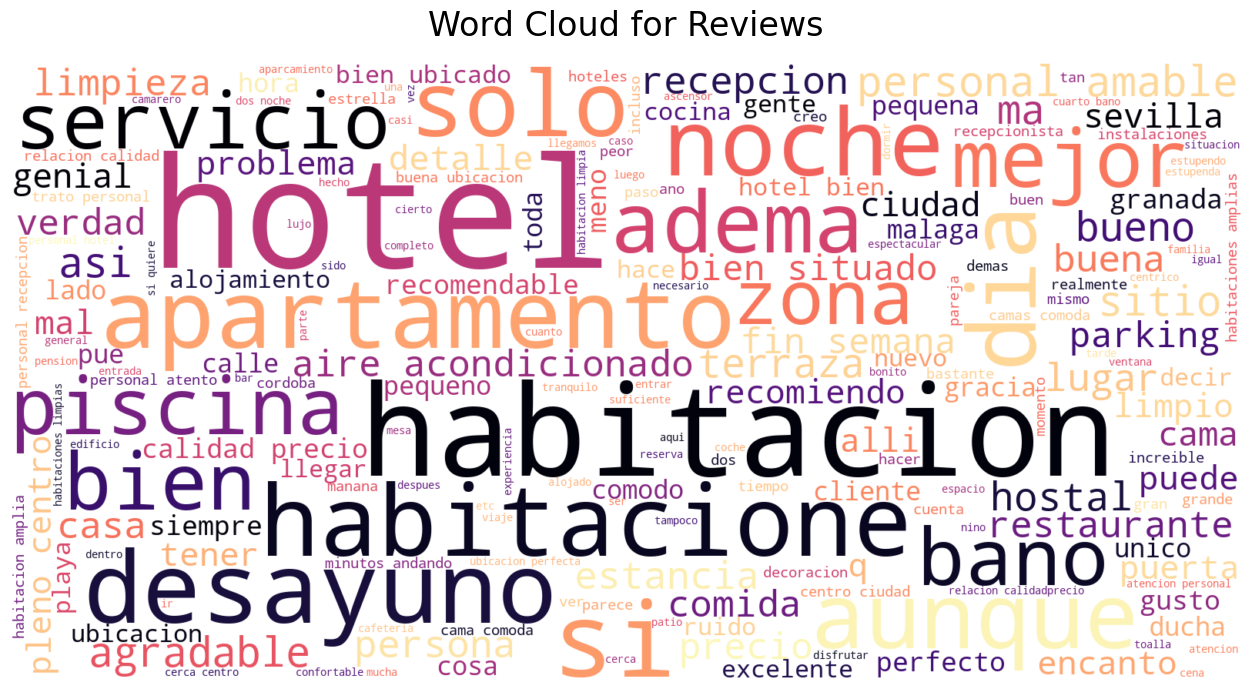

In [468]:
# generate_wordcloud(reviews_df, "review_text")

### 3.1. Manual review

In [469]:
# Delete words that may be due to errors
wrong_words = ['ma']
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in wrong_words]))

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:520: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

c:\Users\charl\Desktop\Unive

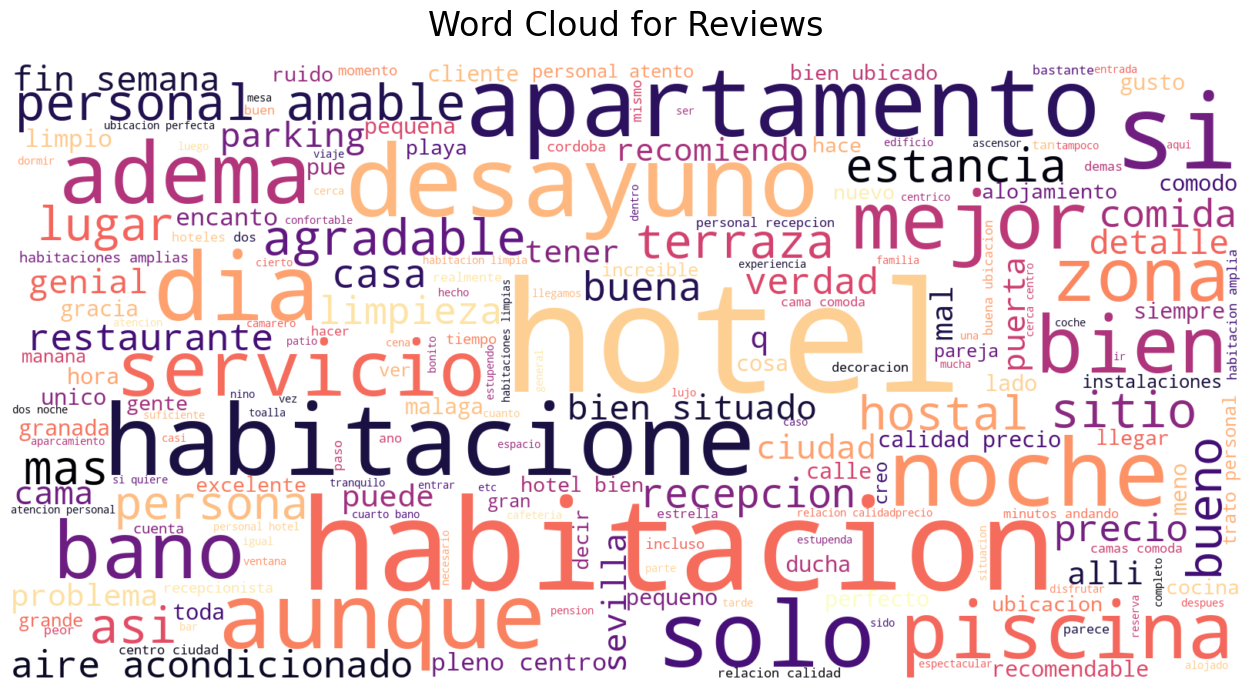

In [470]:
generate_wordcloud(reviews_df, "review_text")

## 4. LDA analysis

### 4.1. Tokenize words

In [471]:
# Donwload the resources for NLTK spanish tokenizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [472]:
# Tokenize the reviews if they are not already tokenized
tokens_df = reviews_df.copy()

tokens_df['review_text'] = tokens_df['review_text'].apply(lambda x: word_tokenize(x, language='spanish') if isinstance(x, str) else x)

### 4.2. TF-IDF Matrix - TRAIN / TEST (?)

In [473]:
# # Initialize the TF-IDF vectorizer
# tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed

# # Fit and transform the tokenized text data
# tfidf_matrix = tfidf_vectorizer.fit_transform(reviews_df['review_text'])

In [474]:
# Tokenize the reviews if they are not already tokenized
tokens_df['review_text'] = tokens_df['review_text'].apply(lambda x: word_tokenize(x, language='spanish') if isinstance(x, str) else x)

# Create Dictionary
id2word = corpora.Dictionary(tokens_df['review_text'])

# Create Corpus
texts = tokens_df['review_text']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


## 5. LDA Training

In [475]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.018*"hotel" + 0.016*"habitacion" + 0.012*"habitaciones" + 0.011*"personal" + 0.010*"si" + 0.008*"bien" + 0.007*"desayuno" + 0.005*"bano" + 0.005*"centro" + 0.005*"ubicacion"'), (1, '0.017*"bien" + 0.009*"habitacion" + 0.009*"hotel" + 0.008*"si" + 0.007*"habitaciones" + 0.006*"personal" + 0.006*"lugar" + 0.006*"excelente" + 0.005*"bano" + 0.005*"ciudad"'), (2, '0.013*"habitaciones" + 0.012*"hotel" + 0.012*"habitacion" + 0.010*"personal" + 0.010*"bien" + 0.007*"trato" + 0.007*"si" + 0.006*"buen" + 0.005*"precio" + 0.005*"centro"'), (3, '0.031*"hotel" + 0.015*"habitacion" + 0.011*"bien" + 0.010*"personal" + 0.008*"buena" + 0.007*"desayuno" + 0.005*"ubicacion" + 0.005*"habitaciones" + 0.005*"cerca" + 0.005*"centro"'), (4, '0.015*"hotel" + 0.007*"habitacion" + 0.007*"desayuno" + 0.007*"solo" + 0.007*"personal" + 0.006*"lugar" + 0.006*"si" + 0.006*"bien" + 0.005*"ubicacion" + 0.005*"habitaciones"'), (5, '0.021*"hotel" + 0.013*"habitacion" + 0.009*"bien" + 0.008*"personal" + 0.006*"si

### 5.1. LDA Model training

In [476]:
# # Initialize the LDA model
# lda = LatentDirichletAllocation(n_components=5, random_state=42)  # You can specify the number of topics (n_components)

# # Fit the LDA model to the TF-IDF matrix
# lda.fit(tfidf_matrix)

# # Extract the topic-word distributions
# topic_word_distributions = lda.components_

Better to use gensim library rather than scykitlearn

In [480]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.020*"hotel" + 0.014*"habitacion" + 0.011*"si" + 0.008*"personal" + 0.006*"buena" + 0.005*"centro" + 0.005*"habitaciones" + 0.005*"bano" + 0.005*"bien" + 0.005*"noche"'), (1, '0.019*"hotel" + 0.017*"bien" + 0.010*"personal" + 0.009*"si" + 0.009*"habitacion" + 0.009*"habitaciones" + 0.006*"ubicacion" + 0.006*"cerca" + 0.006*"centro" + 0.005*"desayuno"'), (2, '0.017*"hotel" + 0.014*"habitacion" + 0.010*"personal" + 0.008*"desayuno" + 0.008*"bien" + 0.007*"habitaciones" + 0.006*"buena" + 0.006*"ubicacion" + 0.006*"limpieza" + 0.006*"amable"'), (3, '0.022*"hotel" + 0.010*"habitacion" + 0.009*"personal" + 0.006*"desayuno" + 0.006*"bien" + 0.006*"ubicacion" + 0.006*"dos" + 0.005*"apartamento" + 0.005*"cama" + 0.005*"habitaciones"'), (4, '0.028*"hotel" + 0.025*"habitacion" + 0.007*"bien" + 0.007*"si" + 0.006*"bano" + 0.006*"habitaciones" + 0.006*"desayuno" + 0.005*"personal" + 0.004*"buena" + 0.004*"recepcion"'), (5, '0.019*"hotel" + 0.009*"habitaciones" + 0.008*"personal" + 0.008*"hab

In [478]:
# Function to display the top words for each topic
# def display_topics(model, feature_names, num_top_words=10):
#     for topic_idx, topic in enumerate(model.components_):
#         top_words_idx = topic.argsort()[-num_top_words:][::-1]
#         top_words = [feature_names[i] for i in top_words_idx]
#         print(f"Topic {topic_idx}: {', '.join(top_words)}")

# # Display the top words for each topic
# tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
# display_topics(lda, tfidf_feature_names)

### 5.2. Model training

In [481]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.000460  0.009299       1        1  19.828250
4     -0.021709 -0.009584       2        1  14.598725
2     -0.003155  0.001597       3        1  12.453330
7     -0.014813  0.007608       4        1  10.655859
6     -0.000868  0.006054       5        1   8.345731
8      0.018355  0.029652       6        1   8.134137
3     -0.005800 -0.026190       7        1   7.241155
0     -0.020694 -0.007199       8        1   6.674012
5      0.002871  0.010000       9        1   6.238842
9      0.045353 -0.021237      10        1   5.829960, topic_info=             Term          Freq         Total Category  logprob  loglift
8           hotel  13424.000000  13424.000000  Default  30.0000  30.0000
7      habitacion   8731.000000   8731.000000  Default  29.0000  29.0000
10       personal   5670.000000   5670.000000  Default  28.0000  28.0000
76   habitaciones   5160.000000   5160.000000  Default  27.0000  27.0000
26       estancia   1782.000000   1782.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
21          buena    158.342657   3516.777356  Topic10  -5.5553  -0.2584
5        desayuno    168.519840   4283.585913  Topic10  -5.4930  -0.3933
61         limpio    135.378310   2426.437580  Topic10  -5.7120  -0.0439
77          lugar    130.197921   2300.283933  Topic10  -5.7510  -0.0296
172      limpieza    123.719114   2173.508356  Topic10  -5.8020  -0.0239

[853 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
86        1  0.286857    10
86        2  0.125215    10
86        3  0.172266    10
86        4  0.074370    10
86        5  0.073612    10
...     ...       ...   ...
117       6  0.069137  zona
117       7  0.026661  zona
117       8  0.057840  zona
117       9  0.078174  zona
117      10  0.067781  zona

[2193 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 8, 7, 9, 4, 1, 6, 10])